# Bank Customer churn prediction

##Spark set up

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1eispPCMAQvWMcOF6M17LSoo06cMsnBUS'
_, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bank_churn.csv') 

In [ ]:
import pandas as pd

df = pd.read_csv('bank_churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data exploration

In [ ]:
import pandas as pd
import numpy as np

churn_df = pd.read_csv('bank_churn.csv')

In [ ]:
churn_df.shape

(10000, 14)

In [ ]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# check data info
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# check the unique values for each column
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [ ]:
# Get target variable
y = churn_df['Exited']

In [ ]:
# check the propotion of y = 1
# python package: imbalance-learn
print(y.sum() / y.shape * 100)

[20.37]


In [ ]:
# check missing values
churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# continous variable description
churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].describe()

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


In [ ]:
# check the feature distribution
# pandas.DataFrame.describe()
# boxplot, distplot, countplot
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


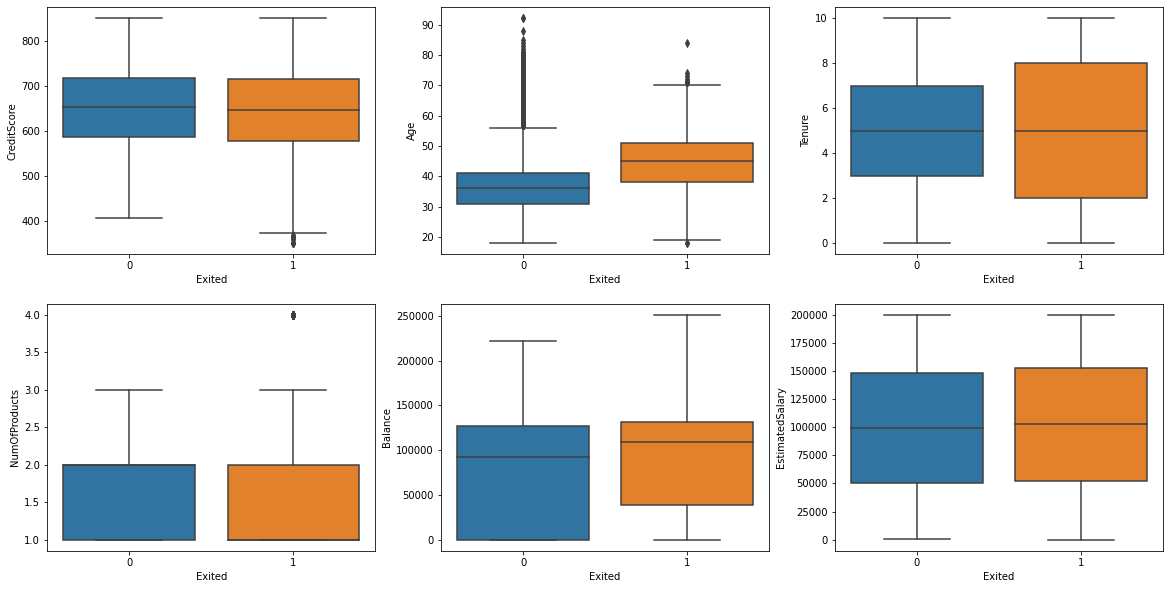

In [ ]:
# boxplot for numerical feature
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axss[1][2])

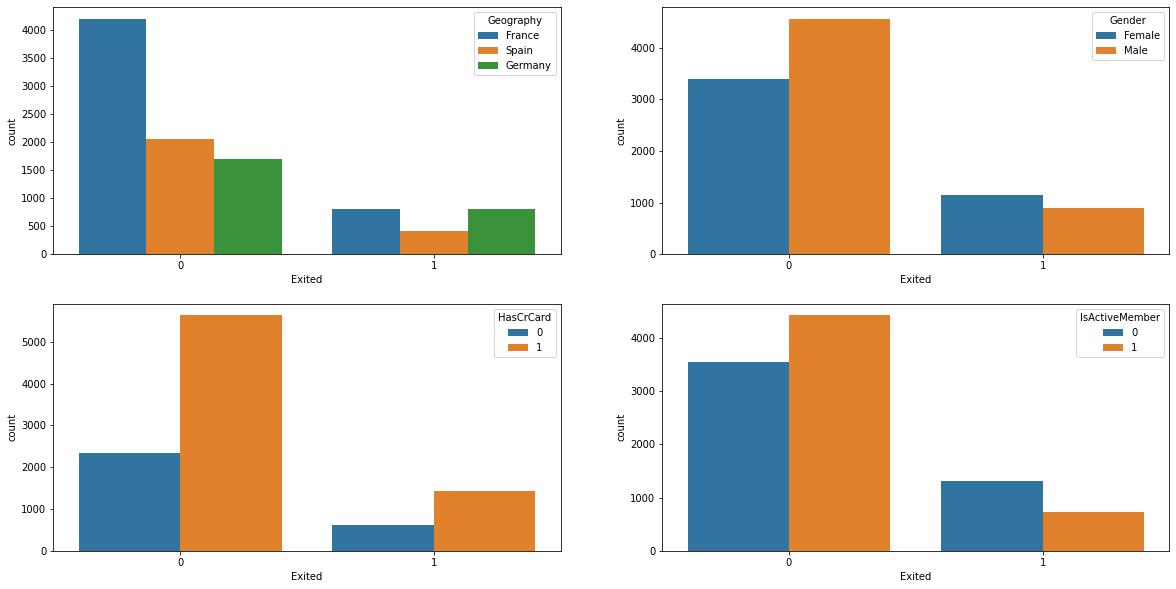

In [ ]:
# understand categorical feature
# 'Geography', 'Gender'
# 'HasCrCard', 'IsActiveMember'
_,axss = plt.subplots(2,2, figsize=[20,10])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axss[1][1])

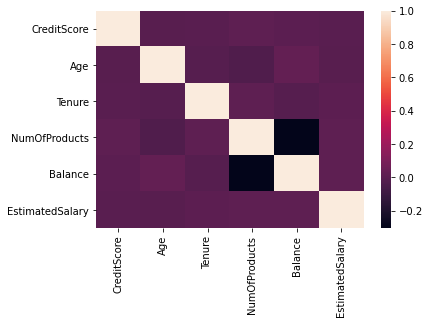

In [ ]:
# correlations between features
corr_score = churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].corr()

# show heapmap of correlations
sns.heatmap(corr_score)

In [ ]:
# check the actual values of correlations
corr_score

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
CreditScore,1.000000,-0.003965,0.000842,0.012238,0.006268,-0.001384
Age,-0.003965,1.000000,-0.009997,-0.030680,0.028308,-0.007201
Tenure,0.000842,-0.009997,1.000000,0.013444,-0.012254,0.007784
NumOfProducts,0.012238,-0.030680,0.013444,1.000000,-0.304180,0.014204
Balance,0.006268,0.028308,-0.012254,-0.304180,1.000000,0.012797
EstimatedSalary,-0.001384,-0.007201,0.007784,0.014204,0.012797,1.000000


## Feature preprocessing

In [ ]:
# ordinal encoding
churn_df['Gender'] = churn_df['Gender'] == 'Female'

In [ ]:
# one hot encoding
churn_df = pd.get_dummies(churn_df, columns=['Geography'], drop_first=False)

In [ ]:
churn_df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,True,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,True,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,True,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,True,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,True,43,2,125510.82,1,1,1,79084.10,0,0,0,1
5,6,15574012,Chu,645,False,44,8,113755.78,2,1,0,149756.71,1,0,0,1
6,7,15592531,Bartlett,822,False,50,7,0.00,2,1,1,10062.80,0,1,0,0
7,8,15656148,Obinna,376,True,29,4,115046.74,4,1,0,119346.88,1,0,1,0
8,9,15792365,He,501,False,44,4,142051.07,2,0,1,74940.50,0,1,0,0
9,10,15592389,H?,684,False,27,2,134603.88,1,1,1,71725.73,0,1,0,0


In [ ]:
# Get feature space by dropping useless feature
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = churn_df.drop(to_drop, axis=1)

## Model training and result evaluation

In [ ]:
# Splite data into training and testing
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7500 observation with 12 features
test data has 2500 observation with 12 features


In [ ]:
# data standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

#Lightgbm
classifier_lgbm = lgb.LGBMClassifier()

In [ ]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','Random Forest','Lightgbm']
model_list = [classifier_logistic, classifier_RF, classifier_lgbm]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.81933333 0.80666667 0.80666667 0.80933333 0.82      ]
Model accuracy of Logistic Regression is 0.8124
[0.88       0.86466667 0.85466667 0.856      0.86333333]
Model accuracy of Random Forest is 0.8637333333333335
[0.866      0.87266667 0.85666667 0.86       0.87133333]
Model accuracy of Lightgbm is 0.8653333333333333


## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

###Logistic regression

In [ ]:
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 1, 5, 10) 
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (0.01, 1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.8124
Best parameters set:
C:1
penalty:l2


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

In [ ]:
best_LR_model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### LGBM

In [ ]:
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_LGBM = GridSearchCV(lgb.LGBMClassifier(),parameters, cv=5)
Grid_LGBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [40, 60, 80]}, pre_dispatch='2*n_jobs',
             

In [ ]:
# best number of trees
print_grid_search_metrics(Grid_LGBM)

Best score: 0.8652000000000001
Best parameters set:
n_estimators:60


In [ ]:
# best lgbm
best_LGBM_model = Grid_LGBM.best_estimator_

In [ ]:
best_LGBM_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=60, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Random Forest

In [ ]:
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.8634666666666666
Best parameters set:
n_estimators:80


In [ ]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [ ]:
best_RF_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Model evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.8572
precision is: 0.7620689655172413
recall is: 0.43418467583497056


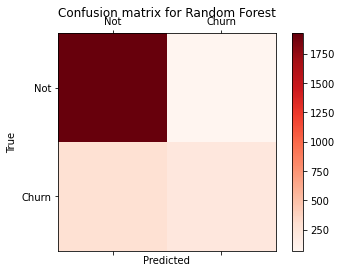

Logistic Regression
Accuracy is: 0.808
precision is: 0.5857988165680473
recall is: 0.1944990176817289


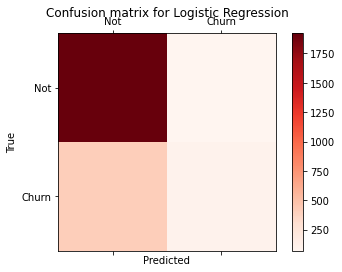

lgbm
Accuracy is: 0.858
precision is: 0.7436708860759493
recall is: 0.46168958742632615


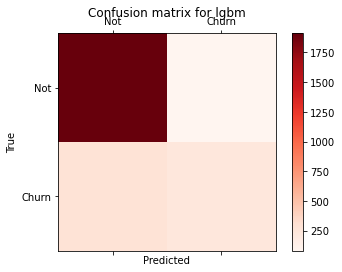

In [ ]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("lgbm", confusion_matrix(y_test, best_LGBM_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

In [ ]:
confusion_matrix(y_test,best_LGBM_model.predict(X_test))

array([[1910,   81],
       [ 274,  235]])

### ROC AUC

### Random forest

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [ ]:
best_RF_model.predict_proba(X_test)

array([[0.8375, 0.1625],
       [0.9875, 0.0125],
       [0.65  , 0.35  ],
       ...,
       [0.875 , 0.125 ],
       [0.9625, 0.0375],
       [0.9   , 0.1   ]])

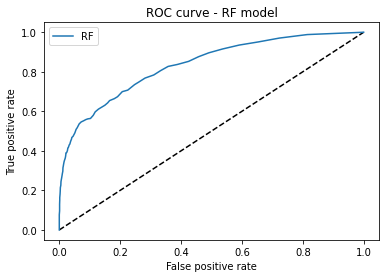

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.8341485604670922

### Logistic Regression

In [ ]:
# Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thres = roc_curve(y_test, y_pred_lr)

In [ ]:
best_LR_model.predict_proba(X_test)

array([[0.82440541, 0.17559459],
       [0.93201435, 0.06798565],
       [0.85485771, 0.14514229],
       ...,
       [0.71400625, 0.28599375],
       [0.89297649, 0.10702351],
       [0.85539214, 0.14460786]])

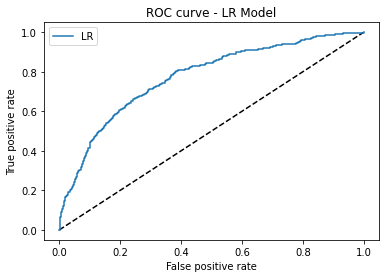

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7722314264879581

###LightGBM

In [ ]:
# LightGBM
y_pred_LGBM = best_LGBM_model.predict_proba(X_test)[:, 1]
fpr_LGBM, tpr_LGBM, thres = roc_curve(y_test, y_pred_LGBM)

In [ ]:
best_LGBM_model.predict_proba(X_test)

array([[0.81873169, 0.18126831],
       [0.95654763, 0.04345237],
       [0.76455527, 0.23544473],
       ...,
       [0.86213212, 0.13786788],
       [0.89424034, 0.10575966],
       [0.96654527, 0.03345473]])

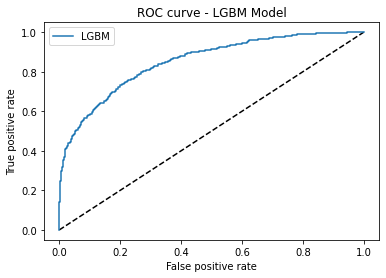

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LGBM, tpr_LGBM, label='LGBM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LGBM Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_LGBM,tpr_LGBM)

0.8507330136893033

## Feature importance

### Random Forest

In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
Age : 0.238
EstimatedSalary : 0.1474
CreditScore : 0.1423
Balance : 0.1421
NumOfProducts : 0.1304
Tenure : 0.0818
IsActiveMember : 0.0402
Geography_Germany : 0.0219
HasCrCard : 0.0191
Gender : 0.0188
Geography_France : 0.0095
Geography_Spain : 0.0085


###LGBM

In [ ]:
# check feature importance of LGBM for feature selection
LGBM = lgb.LGBMClassifier()
LGBM.fit(X, y)

importances = LGBM.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by LGBM Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by LGBM Model:
Balance : 597
EstimatedSalary : 562
CreditScore : 540
Age : 504
Tenure : 231
NumOfProducts : 219
IsActiveMember : 83
Gender : 82
Geography_Germany : 72
Geography_France : 43
HasCrCard : 36
Geography_Spain : 31


### Logistic regression

In [ ]:
X_with_corr = X.copy()
X_with_corr['SalaryInRMB'] = X['EstimatedSalary'] * 6.91
X_with_corr.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,SalaryInRMB
0,619,True,42,2,0.00,1,1,1,101348.88,1,0,0,700320.7608
1,608,True,41,1,83807.86,1,0,1,112542.58,0,0,1,777669.2278
2,502,True,42,8,159660.80,3,1,0,113931.57,1,0,0,787267.1487
3,699,True,39,1,0.00,2,0,0,93826.63,1,0,0,648342.0133
4,850,True,43,2,125510.82,1,1,1,79084.10,0,0,1,546471.1310


In [ ]:
# add L1 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1, solver='liblinear')
LRmodel_l1.fit(X_l1, y)

indices = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print ("Logistic Regression (L1) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]], 4)))

Logistic Regression (L1) Coefficients
Age : 0.7495
IsActiveMember : -0.524
Geography_Germany : 0.3171
Gender : 0.2541
Balance : 0.159
CreditScore : -0.0569
NumOfProducts : -0.0529
Tenure : -0.0384
HasCrCard : -0.013
EstimatedSalary : 0.0123
Geography_France : -0.0122
SalaryInRMB : 0.0078
Geography_Spain : 0.0


In [ ]:
# add L2 regularization to logistic regression
# check the coef for feature selection
np.random.seed()
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1, solver='liblinear', random_state=42)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]], 4)))
  

Logistic Regression (L2) Coefficients
Age : 0.751
IsActiveMember : -0.5272
Gender : 0.2591
Geography_Germany : 0.2279
Balance : 0.162
Geography_France : -0.1207
Geography_Spain : -0.089
CreditScore : -0.0637
NumOfProducts : -0.0586
Tenure : -0.0452
HasCrCard : -0.0199
EstimatedSalary : 0.0137
SalaryInRMB : 0.0137


# Report

**Motivation:**

Customer churn is a very important metrics for company to measure their products. Predicting customers churn can help the company know future behaviors of their customers and then can take actions to improve the outcome.

In this project, logitics regression, random forest and LightGBM models were used to predict the customer churn and hyperparameters were tuned to get the best model.


**Step1: Data exploratory analysis**
* Find the percentage of exited customers
* Generated plots to see the distributions of features in exited group and not exited group
* Caculated the correlation between features

**Step2: Feature preprocessing**
* Did one hot encoding to categorical features 
* Split data into trainning set and testing set
* Data standarization on trainning set

**Step3: Trained LR, RF and LGBM models and tune the hyperparameters**
* LR: l1 and l2 regularization
* RF and LGBM: number of trees

**Step4: Model evalution** 
* Generated confusion matrix to see the performance of three models
* Drawd ROC AUC curve
* Feature importance of RF and LGBM
* Feature coefficient of LR


**Output and Conclusion:**
* Exited percentage is 20%
* LGBM performed best with AUC of 0.8507, precision 0.74 and recall 0.4
* LR's precision is around 0.6 but its recall outperformed the other two models
* I would focus more on accuracy and precision than recall since we do not want to take actions on "will exit customers" to keep them.